In [1]:
from zipfile import ZipFile
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
result_path = Path('./results/')
result_path.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv('data/raw_data.csv')

## Questions

In [4]:
Q1 = 'How many hours on average do you currently review code per week?'
Q2 = 'Do you expect to spend more, less, or same time for code review in five years (in comparison to today)?'
Q3 = 'What software artifacts do you review today?'
Q4 = 'What software artifacts do you anticipate to review in five years?'

# Time spent in code review

Load Stackoverflow Survey data from 2019 as reference

In [5]:
with ZipFile('data/stack-overflow-developer-survey-2019.zip') as z:
    with z.open('survey_results_public.csv') as file:
        stackoverflow_survey = pd.read_csv(file, usecols=['CodeRevHrs']).dropna()

assert stackoverflow_survey.shape[0] == 49790, 'Stack Overflow data appears to be incomplete or incorrectly loaded.'

Data as reported in https://dl.acm.org/doi/abs/10.1109/TSE.2016.2576451

In [6]:
microsoft = pd.Series([0, 0.26, 0.48, 0.21], index=[0, 2, 5, 10], name='microsoft')
microsoft

0     0.00
2     0.26
5     0.48
10    0.21
Name: microsoft, dtype: float64

In [7]:
microsoft_cdf = microsoft.cumsum()
stackoverflow_cdf = stackoverflow_survey.CodeRevHrs.value_counts(normalize=True, dropna=True).sort_index().cumsum()
df_cdf = df[Q1].value_counts(normalize=True).sort_index().cumsum()

(0.0, 10.0)

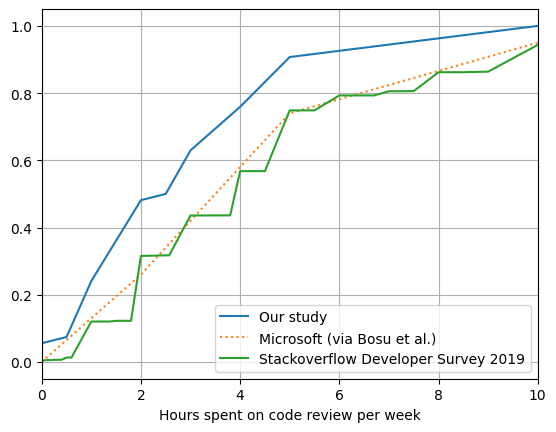

In [8]:
fig, ax = plt.subplots()

df_cdf.plot(label='Our study', ax=ax)
microsoft_cdf.plot(linestyle='dotted', label='Microsoft (via Bosu et al.)', ax=ax)
stackoverflow_cdf.plot(label='Stackoverflow Developer Survey 2019', ax=ax)

ax.set_xlabel('Hours spent on code review per week')
ax.legend(loc='lower right')
ax.grid('both')
ax.set_xlim((0, 10))

In [9]:
for name, _df in (('cdf', df_cdf), ('cdf_microsoft', microsoft_cdf), ('cdf_stackoverflow', stackoverflow_cdf), ):
    _df.to_csv(result_path / f'{name}.csv', header=False)

In [10]:
code_review_hours_df = df[Q2].value_counts(normalize=True)

In [11]:
code_review_hours_df

Do you expect to spend more, less, or same time for code review in five years (in comparison to today)?
More time on code review         0.418182
About the same on code review    0.309091
Less time on code review         0.272727
Name: proportion, dtype: float64

In [12]:
code_review_hours_str = f'''\
\\newcommand{{\\moretime}}{{\\SI{{{code_review_hours_df['More time on code review']*100.0:.0f}}}{{\\percent}}}}
\\newcommand{{\\sametime}}{{\\SI{{{code_review_hours_df['About the same on code review'] * 100.0:.0f}}}{{\\percent}}}}
\\newcommand{{\\lesstime}}{{\\SI{{{code_review_hours_df['Less time on code review'] * 100.0:.0f}}}{{\\percent}}}}\
'''

with open(result_path / 'results.tex', 'w') as f:
    f.write(code_review_hours_str)

## Artifacts

In [13]:
s = df[Q3].str.split(';').explode()
p1 = s[s != ''].rename('artifact').to_frame().reset_index(names='participant').groupby('artifact').participant.nunique().sort_values().rename('Today')/len(df[Q3].index)

In [14]:
s = df[Q4].str.split(';').explode()
p2 = s[s != ''].rename('artifact').to_frame().reset_index(names='participant').groupby('artifact').participant.nunique().sort_values().rename('Tomorrow')/len(df[Q4].index)

In [ ]:
artifacts_df = pd.concat([p1, p2], axis=1)

indices = ['Production code', 'Test code', 'Parameter/configuration files', 'Documentation', 'GUI-based test code (end-to-end testing)', 'None',]
others_indicies = artifacts_df.index.difference(indices)

artifacts_df.loc['Others'] = artifacts_df.loc[others_indicies].sum(skipna=True)
artifacts_df.drop(others_indicies).reindex(indices)

,Today,Tomorrow
artifact,,
Production code,0.763636,0.818182
Test code,0.600000,0.636364
Parameter/configuration files,0.600000,0.672727
Documentation,0.600000,0.672727
GUI-based test code (end-to-end testing),0.218182,0.309091
None,0.090909,0.036364
